In [1]:
import pandas as pd
import sqlite3
import datetime
import os
import sys

In [2]:
ml_dir = os.path.join((os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))), 'findmytie_ml')
print(os.listdir(ml_dir))
sys.path.append(ml_dir)

['scraping', '.DS_Store', 'requirements.txt', 'scalable_instructions.txt', 'datasets', '.gitignore', 'output.png', 'scripts', 'color_grabber', 'venv', 'color_grabber_nn', 'semantic_segmentation']


In [11]:
from color_grabber.color_grabber_v_0_2 import grab_colors 
from semantic_segmentation.semantic_segmentation_v_0 import get_segmentation_mask

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [5]:
print('/Users/sdale/repos/findmytie/findmytie_backend/media/images/61bxHWn6DkL._AC_SX679_.jpg')

/Users/sdale/repos/findmytie/findmytie_backend/media/images/61bxHWn6DkL._AC_SX679_.jpg


/Users/sdale/repos/findmytie/findmytie_backend/media/images/51XhyuCYVdL._AC_SX679_.jpg


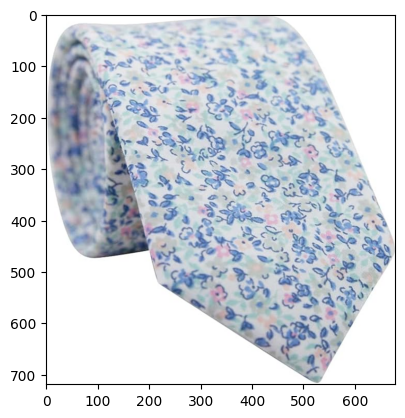

In [41]:
# solid blue
# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/81fJbd4t9kL._AC_SY879_.jpg'

# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/51WNv29TXZL._AC_SX679_.jpg'
# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/61bxHWn6DkL._AC_SX679_.jpg'
path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/51XhyuCYVdL._AC_SX679_.jpg'
# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/61an8ZDZe5L._AC_SX679_.jpg'
# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/61E1ekgK99L._AC_SX679_.jpg'
# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/61DzYRG4dNL._AC_SX679_.jpg'
# path = '/Users/sdale/repos/findmytie/findmytie_backend/media/images/61FoG4EnvDL._AC_SX679_.jpg'

img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(path)

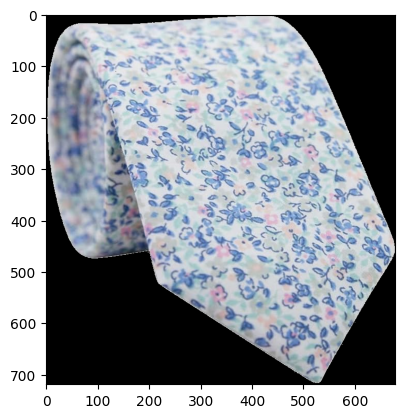

In [42]:
foreground_mask = get_segmentation_mask(img)
foreground_img = cv2.bitwise_and(img, img, mask=foreground_mask)
plt.imshow(cv2.cvtColor(foreground_img, cv2.COLOR_BGR2RGB))

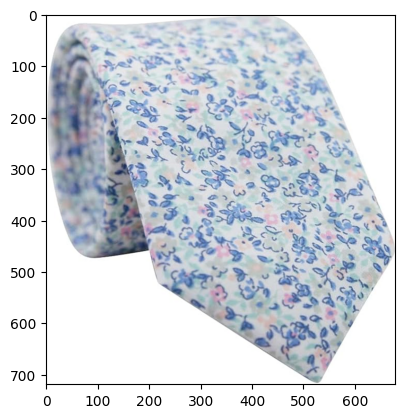

In [43]:
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
plt.imshow(img_rgb)

In [44]:
print(img_lab[:,:,0].min(), img_lab[:,:,0].max())
print(img_lab[:,:,1].min(), img_lab[:,:,1].max())
print(img_lab[:,:,2].min(), img_lab[:,:,2].max())

9 255
113 153
89 138


0.0
0 255 150.15952036149045
162697


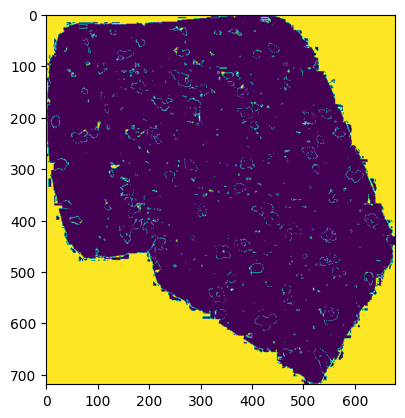

In [45]:
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
ab_sum = img_lab[:,:,1] + img_lab[:,:,2]
th = np.percentile(ab_sum, 10)
print(th)
print(ab_sum.min(), ab_sum.max(), ab_sum.mean())
grey_mask = ab_sum <= th
print(sum(grey_mask.flatten()))
plt.imshow(grey_mask)

Removed 160316 background points
Removing points with L < 123.0
Removed 15751 dark points
Removing points with a+b < 4.0
Removed 42951 grey points


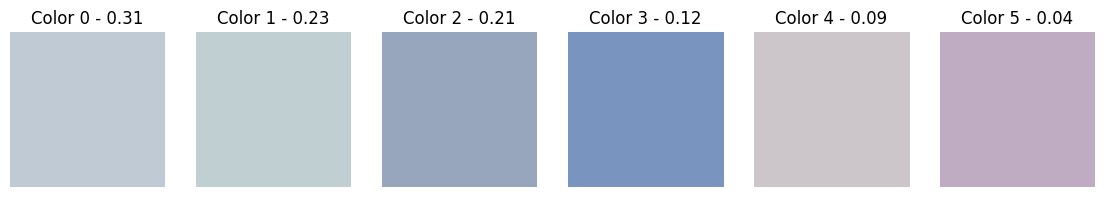

In [46]:
K = 6
N = K
cols = min(8, N)
rows = (N // cols) + 1
fig = plt.figure(figsize=(14, 7)) 
# def grab_colors(
#     img,  # opencv image
#     n_colors=8, 
#     weights=(5, 100, 100, 1, 1), 
#     resize=False,
#     resize_to=SIZE,
#     blur=True, 
#     remove_background=True, 
#     output_format='rgb',
#     remove_dark_points=True,
#     dark_pct_thresh=5,
# ):
centroids, weights, center_points, intertia = grab_colors(
    img=img, 
    n_colors=K, 
    weights=(10, 100, 100, 1, 1), 
    resize=False, 
    blur=False,
    remove_background=True,
    remove_dark_points=True, 
    dark_pct_thresh=5, 
    output_format='rgb',
    remove_grey_points=True,
    grey_pct_thresh=20,
)
sorted_inx = np.argsort(weights)[::-1]
centroids = centroids[sorted_inx[:N]]
weights = weights[sorted_inx[:N]]
center_points = center_points[sorted_inx[:N]]
for i in range(len(weights)):
    fig.add_subplot(rows, cols, i+1) 
    plt.title(f'Color {i} - {weights[i]:.2f}')
    # rgb = [int(x) for x in centroids[i]]
    rgb = [int(x) for x in center_points[i]]
    square = np.full((5, 5, 3), rgb, dtype=np.uint8)
    plt.imshow(square)
    plt.axis('off')

In [36]:
print(sorted_inx.shape)
print(centroids.shape)
print(weights.shape)
print(center_points.shape)

(6,)
(6, 3)
(6,)
(6, 3)


In [ ]:
DB_PATH = '/Users/sdale/repos/findmytie/findmytie_backend/db.sqlite3' 
def get_table_names():
    conn = sqlite3.connect(DB_PATH)
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    conn.close()
    return tables

TABLE_NAMES = {
    'listing': 'api_listing', 
    'search_query': 'api_searchquery',
    'query_match': 'api_querymatch',
}
def get_data():
    conn = sqlite3.connect(DB_PATH)
    df_dict = {}
    for table, table_key in TABLE_NAMES.items():
        query = f"SELECT * FROM {table_key}"
        df = pd.read_sql_query(query, conn)
        df_dict[table] = df
    conn.close()
    return df_dict

def put_data(df_dict: dict):
    conn = sqlite3.connect(DB_PATH)
    for table, df in df_dict.items():
        table_key = TABLE_NAMES[table]
        df.to_sql(table_key, conn, if_exists='replace', index=False)
    conn.close()

In [ ]:
df_dict = get_data()

In [ ]:
# remove all matches
put_data({'query_match': pd.DataFrame(columns=df_dict['query_match'].columns)})

In [ ]:
df_dict['listing'].head()

In [ ]:
ml_df = pd.read_csv('manual_listings.csv')

In [ ]:
ml_df.head()

In [ ]:
print(sorted(ml_df.columns))
print(sorted(df_dict['listing'].columns))

In [ ]:
ml_df['image'] = ml_df['internal_image_path'].apply(lambda x: x.replace('media/', ''))
ml_df.drop(columns=['internal_image_path'], inplace=True)
ml_df['created_at'] = datetime.datetime.now()
ml_df['id'] = ml_df.index + 1
ml_df['colors'] = ''

In [ ]:
datetime.datetime.now()

In [ ]:
print(sorted(ml_df.columns))
print(sorted(df_dict['listing'].columns))

In [ ]:
put_data({'listing': ml_df})

In [ ]:
dt = df_dict['query_match'].iloc[0]['created_at']
print(dt)

In [ ]:
# parse datetime for date and time
dt_obj = datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S.%f')
print(dt_obj)
print(type(dt_obj))
print(type(dt))
print(dt_obj.date())

In [ ]:
# get yesterday's date
yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
print(f"Yesterday: {yesterday}")

In [ ]:
# remove rows that are older than yesterday
for table in ('query_match', 'search_query'):
    df = df_dict[table]
    print(f"{table} before: {len(df)}")
    for i, row in df.iterrows():
        dt = row['created_at']
        dt_obj = datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S.%f')
        print(f"\t{dt_obj.date()} - {dt_obj.strftime("%H:%M:%S")} - {dt_obj.date() < yesterday.date()}")
        if dt_obj.date() < yesterday.date():
            df.drop(i, inplace=True)
    print(f"{table} after: {len(df)}")

In [ ]:
# check for dangling references, remove them
dangling_query_matches = []
search_query_ids = df_dict['search_query']['id'].values
for i, row in df_dict['query_match'].iterrows():
    query_id = row['search_query_id']
    if query_id not in search_query_ids:
        dangling_query_matches.append(i)
print(f"found {len(dangling_query_matches)} dangling query matches")
df_dict['query_match'].drop(dangling_query_matches, inplace=True)

In [ ]:
# Close the connection
conn.close()